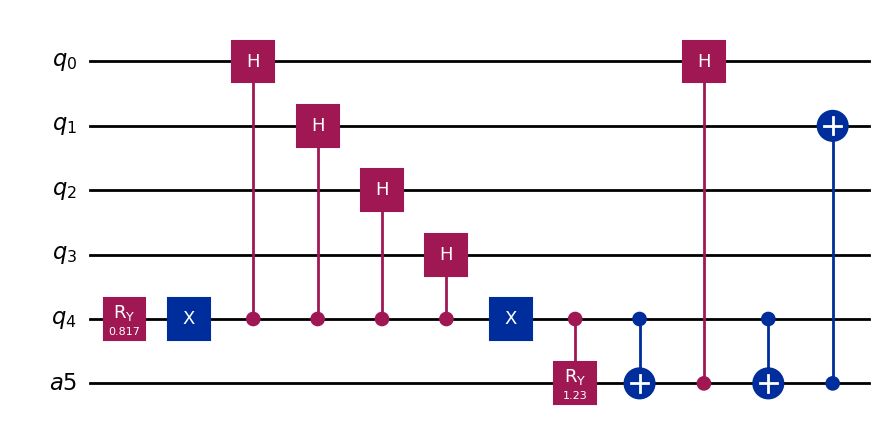

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, AncillaRegister, QuantumCircuit
import numpy as np

class Divider:

    def __init__(self,n):
        self.__n = n
        self.__bits_n = int(np.log2(self.__n))
        self.__active = self.__bits_n

        qr = QuantumRegister(self.__bits_n+1, 'q')
        self.__qc = QuantumCircuit(qr)

    def loop(self,n1,i):
        b1 = self.__bits_n-i
        n2 = 2**b1

        a = 2*np.arcsin(np.sqrt((n1-n2)/n1))
        # print(f'Ry{i+1}: {a}')

        if i>0:
            # ar = AncillaRegister(1,f'a{self.__active}')
            ar = QuantumRegister(1,f'a{self.__active}')
            self.__qc.add_register(ar)
        
        if i==0:
            if (a>0):
                self.__qc.ry(a, self.__active)
        else:
            if (a>0):
                self.__qc.cry(a, self.__active-1, self.__active)
        
        if i==0:
            self.__qc.x(self.__active)
        else:
            self.__qc.cx(self.__active-1, self.__active)
        
        for h in range(0,b1):
            self.__qc.ch(self.__active, h)
        
        if i==0:
            self.__qc.x(self.__active)
        else:
            self.__qc.cx(self.__active-1, self.__active)
    
        if i>0:
            self.__qc.cx(self.__active,b1)
    
        # self.__qc.barrier() # Barrier to better display each of the iterations
        self.__active +=1

    def create(self):
        n1 = self.__n
        for i in range(0,self.__bits_n):
            if self.__n & 2**(self.__bits_n-i)>0:
                self.loop(n1,i)
                n1 = int(n1-np.power(2,self.__bits_n-i))

    def measure(self):
        cr = ClassicalRegister(self.__bits_n+1,'c')
        self.__qc.barrier()
        self.__qc.add_register(cr)
        self.__qc.measure(range(self.__bits_n+1),range(self.__bits_n+1))
        # self.__qc.measure_all()

    def get_circuit(self):
        return self.__qc

options = 19
div = Divider(options)
div.create()

qc = div.get_circuit()
qc.draw('mpl',fold=False)


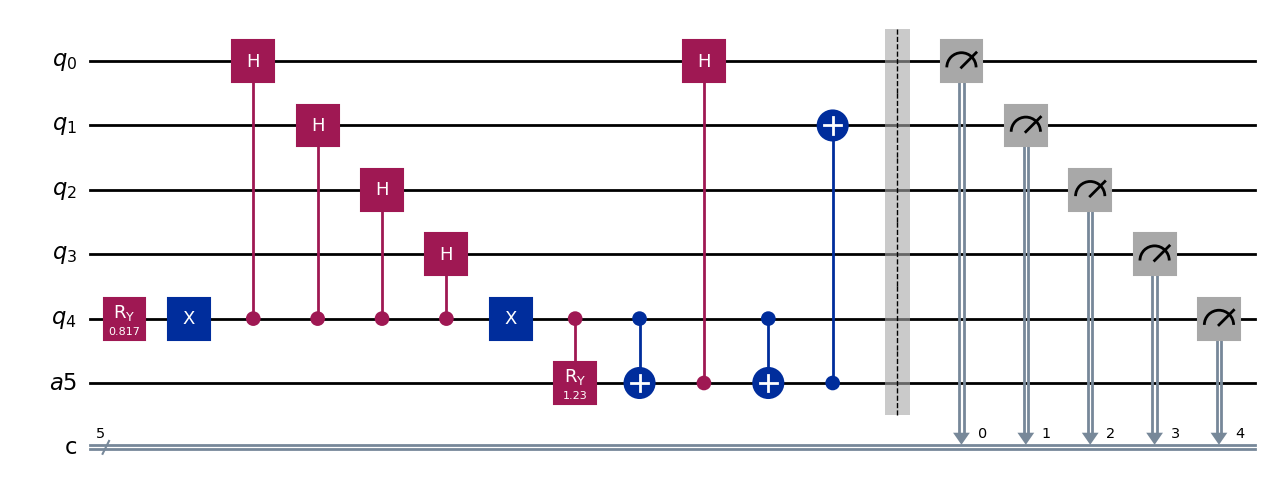

In [2]:
div.measure()
qc = div.get_circuit()
qc.draw('mpl')

In [3]:
import numpy as np

def calculate(p,o):
    n = 0
    nProb = 1.0
    while True:
        n += 1
        nProb = nProb * (o - (n - 1)) / o
        yProb = 1 - nProb
        if yProb >= p:
            return n

prob = 0.9
shots = calculate(prob,options)

print(f'We need {shots} for a {100*prob}% probability of at least one repeated value.')

We need 10 for a 90.0% probability of at least one repeated value.


In [4]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import transpile

sim = AerSimulator()
qct = transpile(qc,sim)
job = sim.run(qct,shots=shots)
result = job.result()
counts= result.get_counts()

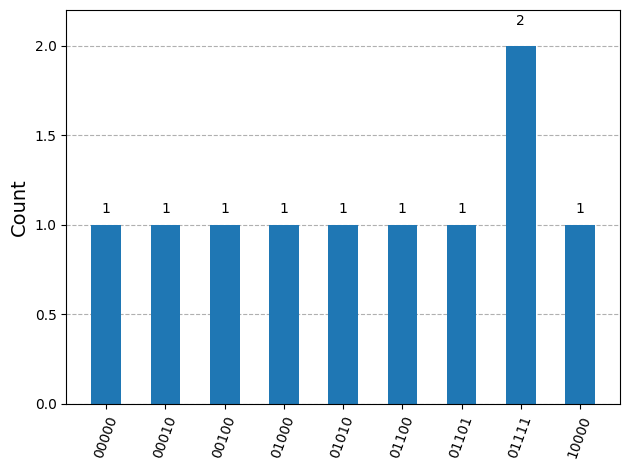

In [5]:
plot_histogram(counts)


In [6]:
from qiskit import transpile, generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2, SamplerOptions

service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True)
print(backend.name)

ibm_torino


In [7]:
options = SamplerOptions(default_shots=shots, max_execution_time=60)
sampler = SamplerV2(mode = backend,options = options)

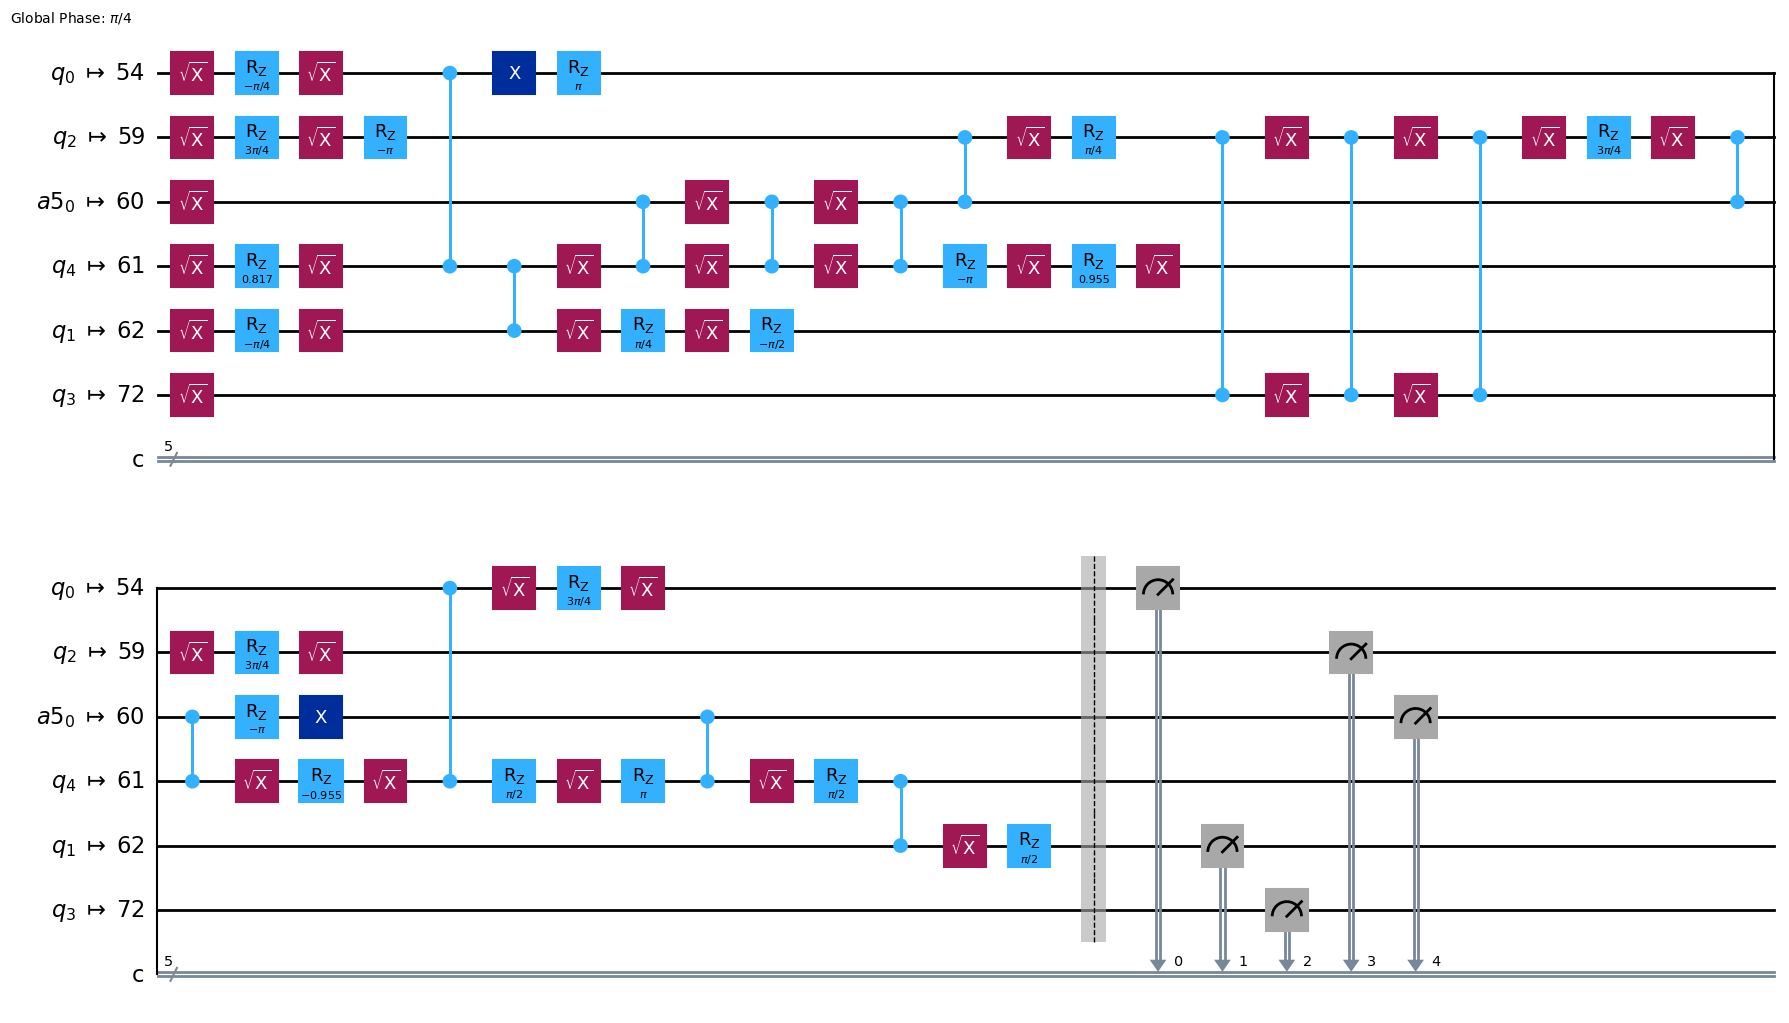

In [8]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
qc_isa = pm.run(qc)
qc_isa.draw('mpl')

In [9]:
job = sampler.run([qc_isa])

In [10]:
job.status()

'QUEUED'

In [11]:
job.error_message()

In [12]:
results = job.result()[0]
counts = results.join_data().get_counts()

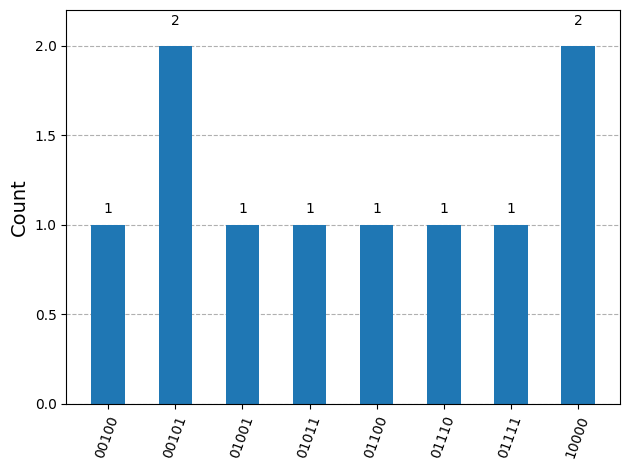

In [13]:
plot_histogram(counts)